In [186]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [187]:
#Importing csv data
states_data = pd.read_csv('4.18states.csv')
counties = pd.read_csv('abridged_couties.csv')
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

In [250]:
#Cleaning Data to answer the following questions
#We will first create tables only where California is concerned
ca_data = states_data[states_data["Province_State"] == 'California']
ca_counties = counties[counties["State"] == 'California'][["countyFIPS", 'PopulationEstimate2018', "PopulationDensityperSqMile2010", "MedicareEnrollment,AgedTot2017", "SVIPercentile"]]

#Percentiles should not be negative
ca_counties = ca_counties[ca_counties["SVIPercentile"] > 0]
ca_deaths = deaths[deaths["Province_State"] == 'California']

#We only care about the total deaths, which is found in column 4/18/20
ca_deaths = ca_deaths[["FIPS", "4/18/20"]]
ca_deaths.columns = ["FIPS", "deaths"]

confirmed_ca = confirmed[confirmed["Province_State"] == "California"]
#We only care about total confirmed cases, which is also the column 4/18/20
confirmed_ca = confirmed_ca[["FIPS", "4/18/20"]]
confirmed_ca.columns = ["FIPS", "confirmed"]

#convert String FIPS to float so we can use it in conjunction with other tables
ca_counties["countyFIPS"] = ca_counties["countyFIPS"].apply(lambda x: float(x))
#Join deaths and confirmed columns into counties table using FIPS. Remove counties without sufficient death data.
ca_counties = ca_counties.join(other = ca_deaths, lsuffix = "countyFIPS", rsuffix = "FIPS")
ca_counties = ca_counties.join(other = confirmed_ca, lsuffix = "countyFIPS", rsuffix = "FIPS")
ca_counties = ca_counties.fillna(-1)
ca_counties = ca_counties[ca_counties["deaths"] > 0]
ca_counties = ca_counties[ca_counties["confirmed"] > 0]
ca_counties = ca_counties.drop(["FIPSFIPS", "FIPScountyFIPS"], axis = 1)
ca_counties = ca_counties[ca_counties["deaths"] + ca_counties["confirmed"] != 0]
ca_counties["confirm_perc"] = ca_counties["confirmed"]/ca_counties["PopulationEstimate2018"]

Text(0.5, 1.0, 'SVIPercentile vs confirmed cases')

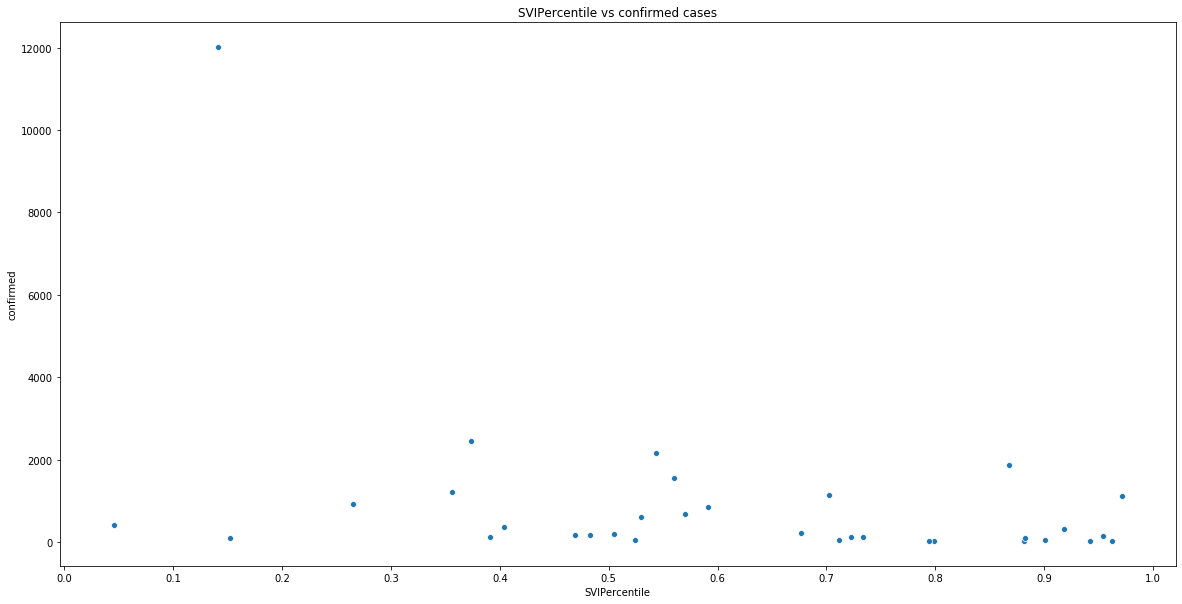

In [209]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(ca_counties["SVIPercentile"], ca_counties["confirmed"])
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title("SVIPercentile vs confirmed cases")

In [190]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr, te = train_test_split(ca_counties, test_size=0.2)

In [198]:
#Our training features don't require the IDs, the death count, or the confirmed count.
#Our used features are 2018 Population, Population Density, Medicare Enrollment, SVI Percentile (an indicator of at risk cities)
x_tr = tr.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_tr = tr["confirm_perc"]
x_te = te.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_te = te["confirm_perc"]

#Using Logistic Regression, we predict the number of confirmed cases 
model = LinearRegression()
model.fit(x_tr, y_tr)
y_pred = model.predict(x_te)

#Function that computes RMSE
def computeRMSE(y, y_hat):
    return np.sqrt(1/(len(y)) * np.sum((y - y_hat) * (y - y_hat)))

#Function that computes cross_validation
def cross_validate_rmse(model, tr_x, tr_y, n):
    model = clone(model)
    n_fold = KFold(n_splits=n)
    rmse_values = []
    for tr_ind, va_ind in n_fold.split(tr_x):
        model.fit(tr_x.iloc[tr_ind,:], tr_y.iloc[tr_ind])
        rmse_values.append(computeRMSE(tr_y.iloc[va_ind], model.predict(tr_x.iloc[va_ind,:])))
    return np.mean(rmse_values)

print(computeMSE(y_te, y_pred))
print(cross_validate_rmse(model, x_tr, y_tr, 5))


986205.3
1458.6277676541308


Initially, we wished to train on the California data because we wanted to predict if different confirmed cases in Californian counties. However, because many Californian counties didn't actually report their number of cases, we lost a lot of data. Having too little training data has negatively impacted our performance, as can be seen by computing MSE. Next, we will attempt to use the entirety of the US as training data.

In [247]:
#This follows the same process as the first few cells. We only take the features we want and rename the date column to something more meaningful.
clean_counties = counties[["countyFIPS", 'PopulationEstimate2018', "PopulationDensityperSqMile2010", "MedicareEnrollment,AgedTot2017", "SVIPercentile"]]
clean_counties = clean_counties[clean_counties["SVIPercentile"] > 0]
clean_counties = clean_counties[clean_counties["PopulationEstimate2018"] > 0]
clean_counties = clean_counties[clean_counties["MedicareEnrollment,AgedTot2017"] > 0]

clean_deaths = deaths[["FIPS", "4/18/20"]]
clean_deaths.columns = ["FIPS", "deaths"]
clean_deaths["deaths"] = clean_deaths["deaths"]
clean_confirm = confirmed[["FIPS", "4/18/20"]]
clean_confirm.columns = ["FIPS", "confirmed"]


#Hardcoding the removal of two 0-data rows, labeled City 1 and City 2
clean_counties = clean_counties[clean_counties["countyFIPS"] != 'City1']
clean_counties = clean_counties[clean_counties["countyFIPS"] != 'City2']
clean_counties["countyFIPS"] = clean_counties["countyFIPS"].apply(lambda x: float(x))

#Join deaths and confirmed columns into counties table using FIPS. Remove counties without sufficient death data.
clean_counties = clean_counties.join(other = clean_deaths, lsuffix = "countyFIPS", rsuffix = "FIPS")
clean_counties = clean_counties.join(other = clean_confirm, lsuffix = "countyFIPS", rsuffix = "FIPS")
clean_counties = clean_counties.fillna(-1)
clean_counties = clean_counties[clean_counties["deaths"] >= 0]
clean_counties = clean_counties[clean_counties["confirmed"] >= 0]
clean_counties = clean_counties.drop(["FIPSFIPS", "FIPScountyFIPS"], axis = 1)
#We're going to do a remove rows where deaths and confirmed are 0, because they haven't been infected so are not good indicators.
clean_counties = clean_counties[clean_counties["deaths"] + clean_counties["confirmed"] != 0]
#We are going to change the confirm column into a percentage
clean_counties["confirm_perc"] = clean_counties["confirmed"]/clean_counties["PopulationEstimate2018"]

C:\Users\Frank\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\Frank\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Log Population Density vs Logged Percentage of confirmed cases')

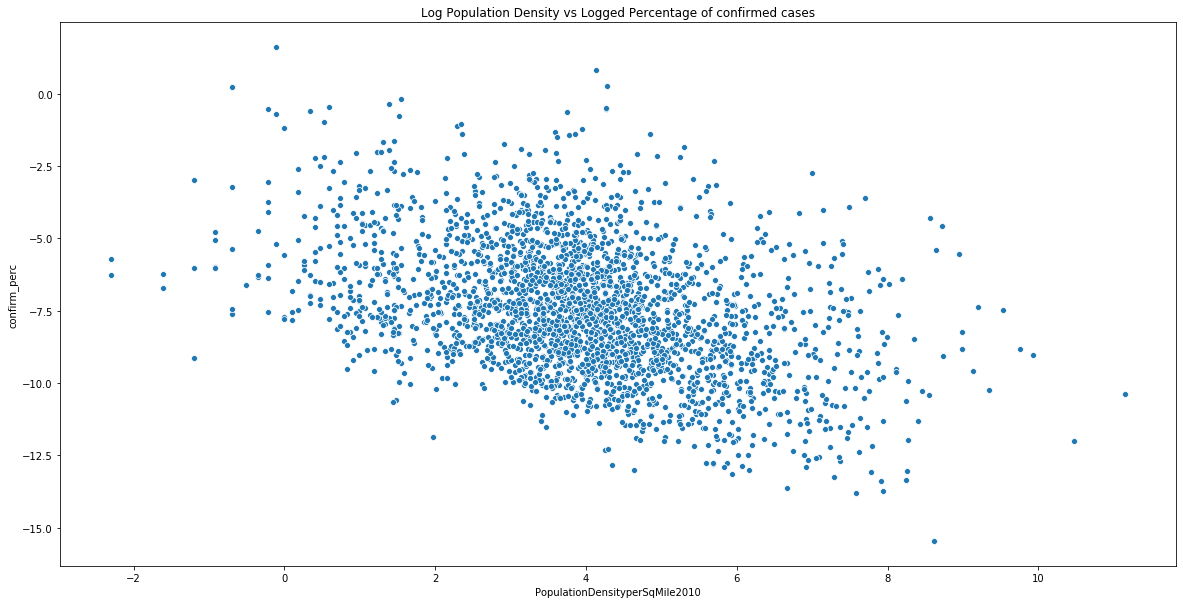

In [338]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(np.log(clean_counties["PopulationDensityperSqMile2010"]), np.log(clean_counties["confirm_perc"]))
plt.title("Log Population Density vs Logged Percentage of confirmed cases")

In [334]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr2, te2 = train_test_split(clean_counties, test_size=0.2)
x_tr2 = tr2.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_tr2 = tr2["confirm_perc"]
x_te2 = te2.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_te2 = te2["confirm_perc"]
#Using Logistic Regression, we predict the number of confirmed cases 
model2 = LinearRegression()
model2.fit(x_tr2, y_tr2)

print(cross_validate_rmse(model2, x_tr2, y_tr2, 5))
y_hat = model2.predict(x_te2)
computeRMSE(y_te2, y_hat)

#This is a function that takes in four feature values as parameters. It will return the predicted proportion of population infected
#given what model2 is trained on. All cells before this must be run however.
def predict(pop, dens, medicare, svi):
    d = {'PopulationEstimate2018': [pop], 'PopulationDensityperSqMile2010': [dens], 'MedicareEnrollment,AgedTot2017' : [medicare], 'SVIPercentile' : [svi]}
    return model2.predict(pd.DataFrame(data = d))
print(predict(45325, 62.9, 4730, 0.2341))

0.10616330796992449
[0.01720072]


We will now use PCA to see if we can find anything interesting with our features

In [339]:
copy1 = clean_counties.copy()
copy = copy1.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
copy_centered = copy - np.mean(copy, axis = 0)
u, s, vt = np.linalg.svd(copy_centered, full_matrices = False)
#sigma_1 is the vector that containing the sigma value corresponding to the first pc
sigma_1 = np.array([s[0], 0, 0, 0])
#to retrieve all the values associated with pc1, we dot product u with sigma1
pc1 = u@sigma_1;
copy1["pc1"] = pc1
copy1

,countyFIPS,PopulationEstimate2018,PopulationDensityperSqMile2010,"MedicareEnrollment,AgedTot2017",SVIPercentile,deaths,confirmed,confirm_perc,pc1
1,1003.0,218022.0,114.7,41590.0,0.2162,5,136,0.000624,-1.083608e+05
2,1005.0,24881.0,31.0,4706.0,0.9959,2,14,0.000563,8.790835e+04
3,1007.0,22400.0,36.8,3389.0,0.6003,60,1118,0.049911,9.053716e+04
4,1009.0,57840.0,88.9,9542.0,0.4242,3,53,0.000916,5.460161e+04
5,1011.0,10138.0,17.5,1434.0,0.8898,2,25,0.002466,1.029484e+05
6,1013.0,19680.0,27.0,3571.0,0.8653,2,109,0.005539,9.321168e+04
7,1015.0,114277.0,195.7,20142.0,0.8252,0,18,0.000158,-2.726893e+03
8,1017.0,33615.0,57.4,6342.0,0.7382,0,26,0.000773,7.903693e+04
9,1019.0,26032.0,46.9,5195.0,0.4516,0,20,0.000768,8.670432e+04
10,1021.0,44153.0,63.0,6786.0,0.7602,0,9,0.000204,6.852847e+04


By observing the patterns of the columns and the values of the PCA, we notice that pc1 is referencing population density. For large values, the pca value takes on a negative number, while for small values below 100, the bigger it gets as density approaches 0. The threshhold for when it becomes positive or negative seems to be around 100.

This tells us that between different counties, population density is the thing that differentiates them from each other the most. This could mean that population density could be a good feature, because infection rates are also closely tied to how close together people are. This is not shown in the graphs of the log of density and percent of people infected, because larger populations might have more people infected, but the percentage rate could be lower depending on the denominator.